In [80]:
%pip install tensorflow
%pip install scikit-learn
%pip install pandas
%pip install seaborn
import csv

import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split

RANDOM_SEED = 42

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.1.2 -> 23.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.1.2 -> 23.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.1.2 -> 23.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.1.2 -> 23.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


# Specify each path

In [81]:
dataset = 'model/keypoint_classifier/keypoint.csv'
model_save_path = 'model/keypoint_classifier/keypoint_classifier.hdf5'
tflite_save_path = 'model/keypoint_classifier/keypoint_classifier.tflite'

# Set number of classes

In [82]:
NUM_CLASSES = 9

# Dataset reading

In [83]:
X_dataset = np.loadtxt(dataset, delimiter=',', dtype='float32', usecols=list(range(1, (21 * 2) + 1)))

In [84]:
y_dataset = np.loadtxt(dataset, delimiter=',', dtype='int32', usecols=(0))

In [85]:
X_train, X_test, y_train, y_test = train_test_split(X_dataset, y_dataset, train_size=0.75, random_state=RANDOM_SEED)

# Model building

In [86]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Input((21 * 2, )),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(20, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])

In [87]:
model.summary()  # tf.keras.utils.plot_model(model, show_shapes=True)

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout_8 (Dropout)         (None, 42)                0         
                                                                 
 dense_12 (Dense)            (None, 20)                860       
                                                                 
 dropout_9 (Dropout)         (None, 20)                0         
                                                                 
 dense_13 (Dense)            (None, 10)                210       
                                                                 
 dense_14 (Dense)            (None, 9)                 99        
                                                                 
Total params: 1,169
Trainable params: 1,169
Non-trainable params: 0
_________________________________________________________________


In [88]:
# Model checkpoint callback
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    model_save_path, verbose=1, save_weights_only=False)
# Callback for early stopping
es_callback = tf.keras.callbacks.EarlyStopping(patience=20, verbose=1)

In [89]:
# Model compilation
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Model training

In [90]:
model.fit(
    X_train,
    y_train,
    epochs=1000,
    batch_size=128,
    validation_data=(X_test, y_test),
    callbacks=[cp_callback, es_callback]
)

Epoch 1/1000
35/45 [======================>.......] - ETA: 0s - loss: 2.1033 - accuracy: 0.2772 
Epoch 1: saving model to model/keypoint_classifier\keypoint_classifier.hdf5
45/45 [==============================] - 1s 5ms/step - loss: 2.0947 - accuracy: 0.2701 - val_loss: 1.9774 - val_accuracy: 0.2790
Epoch 2/1000
33/45 [=====================>........] - ETA: 0s - loss: 1.9360 - accuracy: 0.2779
Epoch 2: saving model to model/keypoint_classifier\keypoint_classifier.hdf5
45/45 [==============================] - 0s 3ms/step - loss: 1.9229 - accuracy: 0.2825 - val_loss: 1.7974 - val_accuracy: 0.3838
Epoch 3/1000
31/45 [===================>..........] - ETA: 0s - loss: 1.8254 - accuracy: 0.3168
Epoch 3: saving model to model/keypoint_classifier\keypoint_classifier.hdf5
45/45 [==============================] - 0s 3ms/step - loss: 1.8078 - accuracy: 0.3180 - val_loss: 1.6732 - val_accuracy: 0.4394
Epoch 4/1000
35/45 [======================>.......] - ETA: 0s - loss: 1.7160 - accuracy: 0.3516


In [91]:
# Model evaluation
val_loss, val_acc = model.evaluate(X_test, y_test, batch_size=128)

15/15 [==============================] - 0s 2ms/step - loss: 0.3617 - accuracy: 0.9105


In [92]:
# Loading the saved model
model = tf.keras.models.load_model(model_save_path)

In [93]:
# Inference test
predict_result = model.predict(np.array([X_test[0]]))
print(np.squeeze(predict_result))
print(np.argmax(np.squeeze(predict_result)))

1/1 [==============================] - 0s 43ms/step
[6.6418409e-01 4.5210958e-02 1.5120564e-05 3.5862502e-02 9.3301095e-02
 1.5979603e-01 3.2765357e-13 1.6297856e-03 3.4371160e-07]
0


# Confusion matrix

60/60 [==============================] - 0s 760us/step


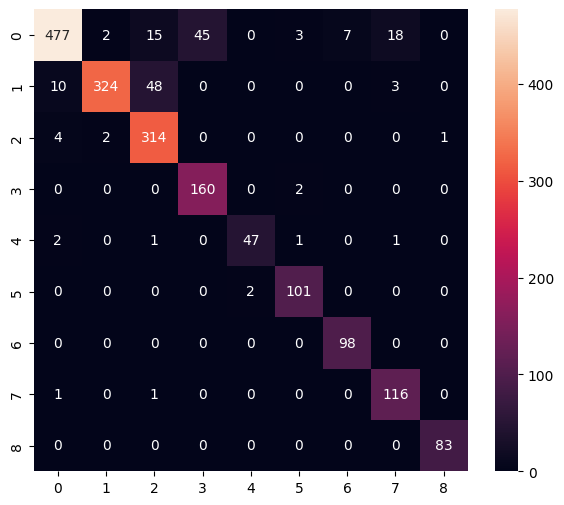

Classification Report
              precision    recall  f1-score   support

           0       0.97      0.84      0.90       567
           1       0.99      0.84      0.91       385
           2       0.83      0.98      0.90       321
           3       0.78      0.99      0.87       162
           4       0.96      0.90      0.93        52
           5       0.94      0.98      0.96       103
           6       0.93      1.00      0.97        98
           7       0.84      0.98      0.91       118
           8       0.99      1.00      0.99        83

    accuracy                           0.91      1889
   macro avg       0.91      0.95      0.93      1889
weighted avg       0.92      0.91      0.91      1889



In [94]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

def print_confusion_matrix(y_true, y_pred, report=True):
    labels = sorted(list(set(y_true)))
    cmx_data = confusion_matrix(y_true, y_pred, labels=labels)
    
    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)
 
    fig, ax = plt.subplots(figsize=(7, 6))
    sns.heatmap(df_cmx, annot=True, fmt='g' ,square=False)
    ax.set_ylim(len(set(y_true)), 0)
    plt.show()
    
    if report:
        print('Classification Report')
        print(classification_report(y_test, y_pred))

Y_pred = model.predict(X_test)
y_pred = np.argmax(Y_pred, axis=1)

print_confusion_matrix(y_test, y_pred)

# Convert to model for Tensorflow-Lite

In [95]:
# Save as a model dedicated to inference
model.save(model_save_path, include_optimizer=False)

In [96]:
# Transform model (quantization)

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quantized_model = converter.convert()

open(tflite_save_path, 'wb').write(tflite_quantized_model)

INFO:tensorflow:Assets written to: C:\Users\JUSTIN~1\AppData\Local\Temp\tmp394g4n_o\assets


INFO:tensorflow:Assets written to: C:\Users\JUSTIN~1\AppData\Local\Temp\tmp394g4n_o\assets


6828

# Inference test

In [97]:
interpreter = tf.lite.Interpreter(model_path=tflite_save_path)
interpreter.allocate_tensors()

In [98]:
# Get I / O tensor
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

In [99]:
interpreter.set_tensor(input_details[0]['index'], np.array([X_test[0]]))

In [100]:
%%time
# Inference implementation
interpreter.invoke()
tflite_results = interpreter.get_tensor(output_details[0]['index'])

CPU times: total: 0 ns
Wall time: 0 ns


In [101]:
print(np.squeeze(tflite_results))
print(np.argmax(np.squeeze(tflite_results)))

[6.6418415e-01 4.5210946e-02 1.5120581e-05 3.5862517e-02 9.3301095e-02
 1.5979601e-01 3.2765484e-13 1.6297866e-03 3.4371129e-07]
0
